<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/4467/logos/front_page.png", style="float:left;width:100px;height:50px;">

<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/4467/media/dozer.png", style="float:left;width:400px;height:200px;">

- 건설 장비 업체. 각종 장비에 들어가는 tubing 의 가격 예측 모델 만들기
- 평가: RMSLE (Root Mean Squared Logarithmic Error)
- [kaggle link](https://www.kaggle.com/c/caterpillar-tube-pricing)

In [14]:
# 기본 tool
import pandas as pd 
import numpy as np
import time
#시각화
from matplotlib import pyplot as plt
# validation
from sklearn.cross_validation import KFold
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb 
from xgboost.sklearn import XGBRegressor
%matplotlib inline 

### Data Import

In [48]:
fin_train_df = pd.read_csv('my_train1.csv')
log_df_y = pd.read_csv('my_log_df_y1.csv')
fin_test = pd.read_csv('my_test1.csv')
test_id = pd.read_pickle('test_id')

### Model Selection

In [51]:
X_train, X_val, y_train, y_val = train_test_split(fin_train_df, log_df_y, random_state=1)

In [18]:
# Grid Search CV
def model_cv(train, test, train_y, test_y, model, name):
    model.fit(train, train_y.values.ravel())
    print(name,': ', model.best_params_)
    pred_y = model.predict(test)
    print('train r2 score: {}'.format(model.score(train, train_y)))
    print('test r2 score: {}'.format(model.score(test, test_y)))
    print('rmsle: {}'.format(mean_squared_error(test_y, pred_y)**0.5))

In [19]:
# Models 
def linearreg(train, test, train_y, test_y):
    lr = LinearRegression()
    param = [{'fit_intercept' : [True, False],
              'normalize' : [True, False]
             }]
    model = GridSearchCV(lr, param, n_jobs = 4, cv=3, scoring = 'r2')
    name = 'Linear Regression'
    return model_cv(train, test, train_y, test_y, model, name)
    
def randomforest(train, test, train_y, test_y):
    param = [{'n_estimators':[100, 300, 600, 1000, 3000],
              'max_features': ['sqrt', 'log2']
            }]
    model = GridSearchCV(RandomForestRegressor(random_state=1), param, cv=3, scoring = 'r2')
    name = 'Random forest'
    return model_cv(train, test, y_train, y_val, model, name)

def XGboost(train, test, train_y, test_y):
    param = [{'n_estimators': [100, 300, 500, 1000],
              'learning_rate': [0.01, 0.03, 0.06, 0.1],
              'max_depth' : [3, 5, 7],
              }]
    model = GridSearchCV(XGBRegressor(), param, cv=3, scoring= 'r2')
    name = 'XGBoost'
    return model_cv(train, test, train_y, test_y, model, name)

#### (1) Linear Regression

In [20]:
%%time
linearreg(X_train, X_val, y_train, y_val)

Linear Regression :  {'fit_intercept': True, 'normalize': False}
train r2 score: 0.3797892982743528
test r2 score: 0.3550870516981265
rmsle: 0.6521024159340879
Wall time: 11.5 s


#### (2) Random Forest

In [21]:
%%time
randomforest(X_train, X_val, y_train, y_val)

Random forest :  {'max_features': 'sqrt', 'n_estimators': 3000}
train r2 score: 0.9849900201455312
test r2 score: 0.8991707358367956
rmsle: 0.25784490832022156
Wall time: 14min 2s


In [22]:
%%time
model_rf = RandomForestRegressor(n_estimators = 3000, max_features = 'sqrt')
model_rf.fit(X_train, y_train.values.ravel())

Wall time: 1min 27s


In [23]:
pred_y_rf = model_rf.predict(fin_test)
pred_y_rf = np.expm1(pred_y_rf)
pred_y_rf = pd.DataFrame(pred_y_rf)
submit_rf = pd.concat([test_id, pred_y_rf], axis = 1)
submit_rf.columns = ['id', 'cost']
# csv 파일로 작성
submit_rf.to_csv('benchmark_rf2.csv', index=False)

- 1차 제출 결과 (without Feature Engineering) 0.338756 
- 2차 제출 결과 (with some Feature Engineering) 0.308647

#### (3) XGBoost

In [30]:
%%time
XGboost(X_train, X_val, y_train, y_val)

XGBoost :  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1000}
train r2 score: 0.9941441277812418
test r2 score: 0.924606592565677
rmsle: 0.22296256237811776
Wall time: 5min 19s


In [52]:
model_xgb = XGBRegressor(max_depth = 7,
                     n_estimators = 1000,
                     learning_rate = 0.1)
model_xgb.fit(X_train, y_train)
pred_y_xgb = model_xgb.predict(fin_test)

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x000001EE5F9AC358>>
Traceback (most recent call last):
  File "C:\Anaconda3\lib\site-packages\xgboost\core.py", line 324, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'


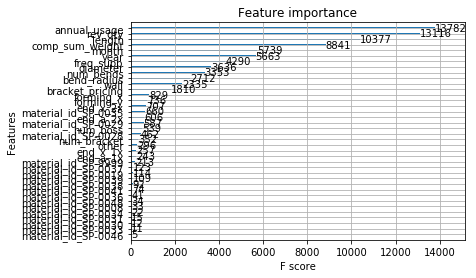

In [53]:
xgb.plot_importance(model)

In [54]:
pred_y_xgb = np.expm1(pred_y_xgb)
pred_y_xgb = pd.DataFrame(pred_y_xgb)
submit_xgb = pd.concat([test_id, pred_y_xgb], axis = 1)
submit_xgb.columns = ['id', 'cost']

In [55]:
submit_xgb.to_csv('benchmark_xgb2.csv', index=False)

- 1차 제출 결과 (without Feature Engineering) 0.329346
- 2차 제출 결과 (with some Feature Engineering) 0.285000

### Conclusion

1. 3가지 모델 중 선형 회귀 모델의 예측 결과값이 가장 좋지 않음 -> quote cost는 선형 모델이 아니라는 것을 알 수 있음.  
   (현실 세계에 선형 모델은 많지 않음)  
2. 주어진 변수에 전처리만 수행한 싱글 모델은 Feature engineering으로 일부 feature를 추가한 모델 대비 예측 결과값이 좋지 않았음  
   - (특히 Kaggle Competition의 경우) 기존 도메인 지식 또는 EDA를 통해 다양한 가설을 세우고 그를 바탕으로 feature를 만드는 것이 Key point임.
3. 결과값이 좋았던 XGBoost, Random Forest 의 hyper parameter를 조정하여 보다 다양한 모델을 조합하여 앙상블 모델을 만든다면 보다 좋은 예측 결과값을 얻을 수 있을 것임.  
    (이 부분은 좀 더 학습 후 추후 보완할 예정.)